In [47]:
from __future__ import division

import numpy as np
import os
from glob import glob
import scipy

from PIL import Image
from copy import deepcopy

from sklearn import linear_model, datasets, neighbors
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm

%matplotlib inline
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable

import pandas as pd
import pickle

VGG_SIZE_X = 224
VGG_SIZE_Y = 224
VGG_SIZE_Z = 3

import sys
sys.path.insert(0, '/home/rslee/sketchfeat/sketches')


import embedding as emb
reload(emb)
from embedding import *


In [2]:
def normalize(X, u, std):

    X = X - u
    X = X / std
    return X

def list_files(path, ext='png'):
    result = [y for x in os.walk(path)
              for y in glob(os.path.join(x[0], '*.%s' % ext))]
    return result

def load_images(paths, num_sketches):
    X = np.empty((num_sketches, VGG_SIZE_X * VGG_SIZE_Y* VGG_SIZE_Z), np.uint8)

    for p_i, p in enumerate(paths):
        im = Image.open(p)
        im = im.convert('RGB')
        im.thumbnail((VGG_SIZE_X, VGG_SIZE_Y), Image.ANTIALIAS)
        img = PIL2array(im)

        X[p_i, :] = img.flatten()
    
    return X

# normalizes images and re-saves accordingly.... 
def normalize_images(paths, num_sketches, train_u, train_std):
    X = np.empty((num_sketches, VGG_SIZE_X * VGG_SIZE_Y* VGG_SIZE_Z), np.uint8)

    for p_i, p in enumerate(paths):
        im = Image.open(p)
        im = im.convert('RGB')
        im.thumbnail((VGG_SIZE_X, VGG_SIZE_Y), Image.ANTIALIAS)
        img = PIL2array(im)

        X[p_i, :] = img.flatten()
    
    return X

def PIL2array(img):

    return np.array(img.getdata(),
                    np.uint8).reshape(img.size[1], img.size[0], 3)

In [17]:
# we will train the network on the baseline_sketches (or sketches from a different dataset)
# TODO: maybe just use the direct matadata file. the only difference should be the 

# get metadata


def get_train_label_from_path(path):
    return path.split('/')[-1].split('_')[0]


def get_train_viewpoint_from_path(path):
    return path.split('/')[-1].split('_')[1]

def get_train_ID_from_path(path):
    return path.split('/')[-1].split('.')[0]


    
# extract metadata
path_to_train = '/home/rslee/baseline_sketches' 
train_paths = list_files(path_to_train)
train_labels = map(get_train_label_from_path,train_paths)
train_viewpoint = map(get_train_viewpoint_from_path, train_paths)
train_ID = map(get_train_ID_from_path, train_paths)

num_train = len(train_paths)

# organize into dataframe
Tr = pd.DataFrame([train_ID, train_labels, train_viewpoint, train_paths])
Tr = Tr.transpose()
Tr.columns = ['trainID', 'label', 'viewpoint', 'path']

print('Number of train sketches: {:d}'.format(len(train_paths)))

Number of train sketches: 1567


In [4]:
# TODO: do I whiten the image ahead of time or can i just normalize the features? 

# X_train = load_images(train_paths, num_train)

# # save the parameters
# train_u = X_train.mean()
# train_std = X_train.std()
    
# _X_train = normalize(X_train, train_u, train_std)

In [80]:
extractor = FeatureExtractor(train_paths,7)
X_train, _ = extractor.extract_feature_matrix()

Batch 5
Batch 10
Batch 15
Batch 20
Batch 25
stopped!


In [81]:

train_u = X_train.mean()
train_std = X_train.std()
_X_train = normalize(X_train, train_u, train_std)

In [82]:
logreg = linear_model.LogisticRegression(solver = 'lbfgs', multi_class = 'multinomial')
trained_classifier = logreg.fit(_X_train, train_labels)

In [92]:
logreg = linear_model.LogisticRegression(penalty = 'l2')
trained_classifier = logreg.fit(_X_train, train_labels)

# Sanity check 

To run thru the log regression 

In [83]:
def get_test_label_from_path(path):
    return path.split('.')[-2].split('_')[-1] 

def get_subj_from_path(path):
    return path.split('/')[-2]

path_to_test = '/home/rslee/sketch_data'
test_paths = list_files(path_to_test)
test_labels = map(get_test_label_from_path,test_paths)
subj = map(get_subj_from_path,test_paths)


print('Number of test sketches: {:d}'.format(len(test_paths)))
print('Number of test subjects: {:d}'.format(len(np.unique(subj))))

Number of test sketches: 1400
Number of test subjects: 35


In [85]:
extractor = FeatureExtractor(test_paths,7)
X_test, _ = extractor.extract_feature_matrix()

Batch 5
Batch 10
Batch 15
Batch 20
stopped!


In [88]:
#load an normalize
_X_test = normalize(X_test, train_u, train_std)

In [93]:
# for time's sake, test on a subset 
trained_classifier.score(_X_test, test_labels)

0.76928571428571424

## with fc6 instead

In [210]:
path_to_test = '/home/rslee/sketch_data/'
test_paths = list_files(path_to_test)
test_labels = map(get_test_label_from_path,test_paths)
subj = map(get_subj_from_path,test_paths)

print('Number of test sketches: {:d}'.format(len(test_paths)))
print('Number of test subjects: {:d}'.format(len(np.unique(subj))))

Number of test sketches: 1400
Number of test subjects: 35


In [211]:
extractor6 = FeatureExtractor(train_paths,6)
X_train6, _ = extractor6.extract_feature_matrix()

Batch 5
Batch 10
Batch 15
Batch 20
Batch 25
stopped!


In [212]:
train_u6 = X_train.mean()
train_std6 = X_train.std()
_X_train6 = normalize(X_train6, train_u6, train_std6)

In [213]:
# logreg6 = linear_model.LogisticRegression(solver = 'lbfgs', multi_class = 'multinomial')
logreg6 = linear_model.LogisticRegression(penalty = 'l2')

trained_classifier6 = logreg6.fit(_X_train6, train_labels)

In [214]:
extractor = FeatureExtractor(test_paths,6)
X_test6, _ = extractor.extract_feature_matrix()

Batch 5
Batch 10
Batch 15
Batch 20
stopped!


In [215]:
#load an normalize
_X_test6 = normalize(X_test6, train_u6, train_std6)

In [216]:
trained_classifier6.score(_X_test6, test_labels)

0.80428571428571427

## sanity checking with subset of final sketches

In [192]:
path_to_test = '/home/rslee/sketch_data/'
test_paths = list_files(path_to_test)
test_labels = map(get_test_label_from_path,test_paths)
subj = map(get_subj_from_path,test_paths)

print('Number of test sketches: {:d}'.format(len(test_paths)))
print('Number of test subjects: {:d}'.format(len(np.unique(subj))))

Number of test sketches: 1400
Number of test subjects: 35


In [194]:
extractor6 = FeatureExtractor(test_paths,6)
X_test6, _ = extractor6.extract_feature_matrix()

Batch 5
Batch 10
Batch 15
Batch 20
stopped!


In [196]:
# logreg6 = linear_model.LogisticRegression(solver = 'lbfgs', multi_class = 'multinomial')
clf = linear_model.LogisticRegression(penalty='l2')
scores = cross_val_score(clf,X_test6,test_labels , cv=5)

In [200]:
print("Accuracy for cross-val of sketches used for testing are %0.2f (+/- %0.2f)" % ( scores.mean(), scores.std() * 2))

Accuracy for final tested sketches are 0.87 (+/- 0.08)


In [209]:
scores = cross_val_score(clf,X_train6,train_labels , cv=5)
print("Accuracy for cross-val of sketches used for training (baseline sketches) are %0.2f (+/- %0.2f)" % ( scores.mean(), scores.std() * 2))

Accuracy for cross-val of sketches used for training (baseline sketches) are 0.85 (+/- 0.02)


## with fc6 instead

In [183]:
path_to_test = '/home/rslee/sketch_data/0110171_neurosketch/'
test_paths = list_files(path_to_test)
test_labels = map(get_test_label_from_path,test_paths)
subj = map(get_subj_from_path,test_paths)

print('Number of test sketches: {:d}'.format(len(test_paths)))
print('Number of test subjects: {:d}'.format(len(np.unique(subj))))

Number of test sketches: 40
Number of test subjects: 1


In [184]:
extractor6 = FeatureExtractor(train_paths,6)
X_train6, _ = extractor6.extract_feature_matrix()

Batch 5
Batch 10
Batch 15
Batch 20
Batch 25
stopped!


In [185]:
train_u6 = X_train.mean()
train_std6 = X_train.std()
_X_train6 = normalize(X_train6, train_u6, train_std6)

In [186]:
# logreg6 = linear_model.LogisticRegression(solver = 'lbfgs', multi_class = 'multinomial')
logreg6 = linear_model.LogisticRegression(penalty = 'l2')

trained_classifier6 = logreg6.fit(_X_train6, train_labels)

In [187]:
extractor = FeatureExtractor(test_paths,6)
X_test6, _ = extractor.extract_feature_matrix()

stopped!


In [188]:
#load an normalize
_X_test6 = normalize(X_test6, train_u6, train_std6)

In [189]:
trained_classifier6.score(_X_test6, test_labels)

0.67500000000000004

# Run thru one sketch progression 

Just a first step 

In [ ]:
# for testing data, we will test for every partial sketch. To just test this, let's just try one set of partial sketches
def get_psketch_ID_from_path(path):
    return path.split('/')[-1].split('.')[0]

In [217]:
trained_classifier.classes_

array(['bed', 'bench', 'chair', 'table'],
      dtype='|S5')

stopped!


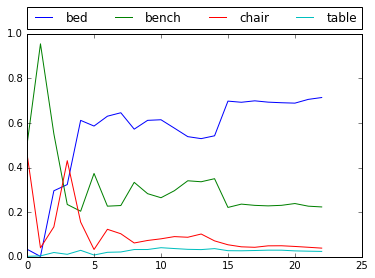

In [152]:
path_to_test = '/home/rslee/partial_sketches/0110171_neurosketch/bed_320'
test_paths = list_files(path_to_test)
test_psketch_ID = map(get_psketch_ID_from_path, test_paths)
# sort by psketchID
psketch_order = np.argsort(np.asarray(test_psketch_ID).astype(int))
_test_paths = [test_paths[i] for i in psketch_order] 

 # extract and normalize
extractor6 = FeatureExtractor(_test_paths,6)
X_test6, _ = extractor6.extract_feature_matrix()
_X_test6 = normalize(X_test6, train_u6, train_std6)

# calculate marginals
prob = np.squeeze(trained_classifier6.predict_proba(_X_test6))

# plot 
plt.plot(prob)
plt.legend(trained_classifier.classes_, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=4, mode="expand", borderaxespad=0.)

stopped!


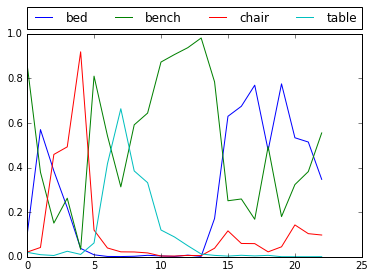

In [154]:
path_to_test = '/home/rslee/partial_sketches/0110171_neurosketch/bench_323'
test_paths = list_files(path_to_test)
test_psketch_ID = map(get_psketch_ID_from_path, test_paths)
# sort by psketchID
psketch_order = np.argsort(np.asarray(test_psketch_ID).astype(int))
_test_paths = [test_paths[i] for i in psketch_order] 

extractor6 = FeatureExtractor(_test_paths,6)
X_test6, _ = extractor6.extract_feature_matrix()

_X_test6 = normalize(X_test6, train_u6, train_std6)

prob = np.squeeze(trained_classifier6.predict_proba(_X_test6))

plt.plot(prob)

plt.legend(trained_classifier.classes_, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=4, mode="expand", borderaxespad=0.)

stopped!


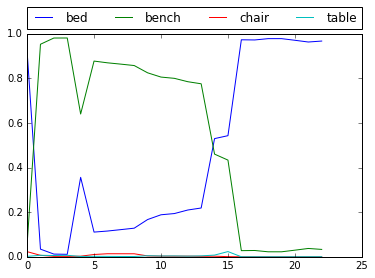

In [151]:
path_to_test = '/home/rslee/partial_sketches/0110171_neurosketch/bench_331'
test_paths = list_files(path_to_test)
test_psketch_ID = map(get_psketch_ID_from_path, test_paths)
# sort by psketchID
psketch_order = np.argsort(np.asarray(test_psketch_ID).astype(int))
_test_paths = [test_paths[i] for i in psketch_order] 

 # extract and normalize
extractor6 = FeatureExtractor(_test_paths,6)
X_test6, _ = extractor6.extract_feature_matrix()
_X_test6 = normalize(X_test6, train_u6, train_std6)

# calculate marginals
prob = np.squeeze(trained_classifier6.predict_proba(_X_test6))

# plot 
plt.plot(prob)
plt.legend(trained_classifier.classes_, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=4, mode="expand", borderaxespad=0.)